### ADS 509
### Assignment 4.1
### Dingyi Duan
#### GitHub: https://github.com/dingyiduan7/ADS_509_module3

## Naive Bayes on Political Text

In this notebook we use Naive Bayes to explore and classify political data. See the `README.md` for full details.

In [1]:
import sqlite3
import nltk
import random
import numpy as np
import re
from collections import Counter, defaultdict

# Feel free to include your text patterns functions
#from text_functions_solutions import clean_tokenize, get_patterns

In [2]:
convention_db = sqlite3.connect("2020_Conventions.db")
convention_cur = convention_db.cursor()

### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [3]:
convention_data = []

# fill this list up with items that are themselves lists. The 
# first element in the sublist should be the cleaned and tokenized
# text in a single string. The second element should be the party. 

query_results = convention_cur.execute(
                            '''
                            SELECT * 
                            FROM Conventions
                            
                            ''')

for row in query_results :
    convention_data.append(row)

Let's look at some random entries and see if they look right. 

In [4]:
random.choices(convention_data,k=10)

[('Democratic',
  4,
  'Joe Biden',
  41,
  '02:15:53',
  'Well, the healthcare system that lowers premiums, deductibles, drug prices. By building on the Affordable Care Act he’s trying to rip away. With an education system that trains our people for the best jobs of the 21st century. There’s not a single thing American workers can’t do. And with cost that doesn’t prevent young people from going to college, and student debt doesn’t crush them when they get out. With a childcare and eldercare system that makes it possible for parents to go to work and for the elderly to stay in their homes with dignity. With an immigration system that powers our economy and reflects our values. And with newly empowered labor unions, they’re the ones that built the middle class. With equal pay for women, with rising wages, you could raise a child on, a family on, and yes we’re going to do more than praise our essential workers.',
  '151',
  'www_rev_com_blog_transcripts2020-democratic-national-convention

In [5]:
# extract the string and party from each record 
# append it to a new list
# replace the old 'convention_data' to the new one
convention_data2 = [[i[5],i[0]] for i in convention_data]
convention_data = convention_data2
convention_data

[['Skip to content The Company Careers Press Freelancers Blog × Services Transcription Captions Foreign Subtitles Translation Freelancers About Contact Login « Return to Transcript Library home  Transcript Categories  All Transcripts 2020 Election Transcripts Classic Speech Transcripts Congressional Testimony & Hearing Transcripts Debate Transcripts Donald Trump Transcripts Entertainment Transcripts Financial Transcripts Interview Transcripts Political Transcripts Press Conference Transcripts Speech Transcripts Sports Transcripts Technology Transcripts Aug 21, 2020 2020 Democratic National Convention (DNC) Night 4 Transcript Rev  ›  Blog  ›  Transcripts  › 2020 Election Transcripts  ›  2020 Democratic National Convention (DNC) Night 4 Transcript Night 4 of the 2020 Democratic National Convention (DNC) on August 20. Read the full transcript of the event here. Transcribe Your Own Content  Try Rev for free  and save time transcribing, captioning, and subtitling.',
  'Democratic'],
 ['I’m 

In [6]:
from nltk.corpus import stopwords

# Stopwords
sw = stopwords.words("english")
sw = [i.replace("'","") for i in sw]  # remove single quote from sw
sw.append('im') # add 'im' to sw - we don't want to see nan's in our tokens


If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [16]:
word_cutoff = 5

tokens = [w for t, p in convention_data for w in t.split()]
tokens = [i for i in tokens if not i in sw] # remove stopwords

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 5, we have 2775 as features in the model.


In [17]:
def conv_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.
       
       Args: 
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word 
            in `text` must be in fw in order to be returned. This 
            prevents us from considering very rarely occurring words.
        
       Returns: 
            A dictionary with the words in `text` that appear in `fw`. 
            Words are only counted once. 
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of 
            {'quick' : True,
             'fox' :    True}
        
    """
    
    # find the word in text that is also in fw for once
    # return True if this happens for as many time as it happens
    
    ret_word = [i for i in Counter(str(text).lower().split()) if i in fw]
    ret_bool = [True]*len(ret_word)
    ret_dict = dict(zip(ret_word,ret_bool))
    
    return(ret_dict)

In [18]:
# test
conv_features('QuiCk QuiCk brOwn foX',{'quick','fox','jumps'})

{'quick': True, 'fox': True}

In [19]:
assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'donald':False,'president':True})
assert(conv_features("people are american in america",feature_words)==
                     {'america':True,'american':True,"people":True})

AssertionError: 

In [20]:
print(True if "donald" in feature_words else False)
print(True if "president" in feature_words else False)
print(True if "america" in feature_words else False)
print(True if "american" in feature_words else False)
print(True if "people" in feature_words else False)

False
True
False
False
True


In [21]:
print(conv_features("donald is the president",feature_words))
print(conv_features("people are american in america",feature_words))

{'president': True}
{'people': True}


In [22]:
"""
Let me re-do this..
"""

assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'president': True})
assert(conv_features("people are american in america",feature_words)==
                     {'people': True})

Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [23]:
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]
len(featuresets)

2541

In [24]:
random.seed(20220507)
random.shuffle(featuresets)

test_size = 500

In [25]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.462


In [26]:
classifier.show_most_informative_features(25)

Most Informative Features
             enforcement = True           Republ : Democr =     27.5 : 1.0
                   votes = True           Democr : Republ =     21.6 : 1.0
                 climate = True           Democr : Republ =     17.8 : 1.0
                 destroy = True           Republ : Democr =     17.1 : 1.0
                supports = True           Republ : Democr =     16.1 : 1.0
                   media = True           Republ : Democr =     15.9 : 1.0
                preserve = True           Republ : Democr =     15.1 : 1.0
                  signed = True           Republ : Democr =     15.1 : 1.0
                freedoms = True           Republ : Democr =     14.0 : 1.0
                freedom, = True           Republ : Democr =     13.4 : 1.0
                 private = True           Republ : Democr =     11.9 : 1.0
                freedom. = True           Republ : Democr =     11.5 : 1.0
                    drug = True           Republ : Democr =     10.9 : 1.0

Write a little prose here about what you see in the classifier. Anything odd or interesting?

### My Observations

Every token/feature listed is basically representation of the Republicans as the ratio is overwhelming.

From the features we can see that the Republicans' attitude is more enforcing with some strong words and many issues are addressed such as climate, freedom, drug, armed and veterans, which are pretty close to what Republican represent.



## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [212]:
cong_db = sqlite3.connect("congressional_data.db")
cong_cur = cong_db.cursor()

In [213]:
results = cong_cur.execute(
        '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%'
        ''')

results = list(results) # Just to store it, since the query is time consuming

In [214]:
# eliminate the b-prefix
# Reference: https://stackoverflow.com/questions/41918836/how-do-i-get-rid-of-the-b-prefix-in-a-string-in-python
tweet_data = [[i[2].decode('utf-8'),i[1]] for i in results]

There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [177]:
random.seed(20201014)

tweet_data_sample = random.choices(tweet_data,k=10)
tweet_data_sample

[['Earlier today, I spoke on the House Floor abt protecting health care for women and praised @PPmarmonte for their work on the Central Coast. https://t.co/WqgTRzT7VV',
  'Democratic'],
 ['Go Tribe! #RallyTogether https://t.co/0NXutFL9L5', 'Democratic'],
 ["Apparently, Trump thinks it's just too easy for students overwhelmed by the crushing burden of debt to pay off student loans #TrumpBudget https://t.co/ckYQO5T0Qh",
  'Democratic'],
 ['We’re grateful for our first responders, our rescue personnel, our firefighters, our police, and volunteers who have been working tirelessly to keep people safe, provide much-needed help, while putting their own lives on the line.\n\nhttps://t.co/eZPv0vMIz3',
  'Republican'],
 ['Let’s make it even Greater !! #KAG 🇺🇸 https://t.co/y9qoZD5L2z',
  'Republican'],
 ["We have about 1hr until the @cavs tie up the series 2-2. I'm #ALLin216 @RepBarbaraLee you scared? #roadtovictory",
  'Democratic'],
 ['Congrats to @belliottsd on his new gig at SD City Hall. We 

In [180]:

for tweet, party in tweet_data_sample :
    # use the function we defined before to extract the keyword and predict for the party
    estimated_party = classifier.classify(conv_features(tweet,feature_words))
    
    print(f"Here's our (cleaned) tweet: {tweet}")
    print(f"Actual party is {party} and our classifer says {estimated_party}.")
    print("")
    

Here's our (cleaned) tweet: Earlier today, I spoke on the House Floor abt protecting health care for women and praised @PPmarmonte for their work on the Central Coast. https://t.co/WqgTRzT7VV
Actual party is Democratic and our classifer says Republican.

Here's our (cleaned) tweet: Go Tribe! #RallyTogether https://t.co/0NXutFL9L5
Actual party is Democratic and our classifer says Democratic.

Here's our (cleaned) tweet: Apparently, Trump thinks it's just too easy for students overwhelmed by the crushing burden of debt to pay off student loans #TrumpBudget https://t.co/ckYQO5T0Qh
Actual party is Democratic and our classifer says Republican.

Here's our (cleaned) tweet: We’re grateful for our first responders, our rescue personnel, our firefighters, our police, and volunteers who have been working tirelessly to keep people safe, provide much-needed help, while putting their own lives on the line.

https://t.co/eZPv0vMIz3
Actual party is Republican and our classifer says Republican.

Here'

Now that we've looked at it some, let's score a bunch and see how we're doing.

In [184]:
# dictionary of counts by actual party and estimated party. 
# first key is actual, second is estimated
parties = ['Republican','Democratic']
results = defaultdict(lambda: defaultdict(int))

for p in parties :
    for p1 in parties :
        results[p][p1] = 0


num_to_score = 10000
random.shuffle(tweet_data)

for idx, tp in enumerate(tweet_data) :
    tweet, party = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_party = classifier.classify(conv_features(tweet,feature_words))
    
    results[party][estimated_party] += 1
    
    if idx > num_to_score : 
        break

In [185]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Republican': defaultdict(int,
                         {'Republican': 3948, 'Democratic': 330}),
             'Democratic': defaultdict(int,
                         {'Republican': 5217, 'Democratic': 507})})

### Reflections

We can see that 
for all Republican's tweets: there are 3948 classified as Republican and 330 Democratic;
for all Democratic's tweets: there are 5217 classified as republicans and 507 Democratic.

This shows that our model did a pretty good job on predicting Republicans but fails on predicting Democratic.
This could due to the fact that Naive Bayes model isn't the most accurate classifier, and/or that the Republic speeches contains more unique keywords that are widely used by both parties. 

### Just for fun...

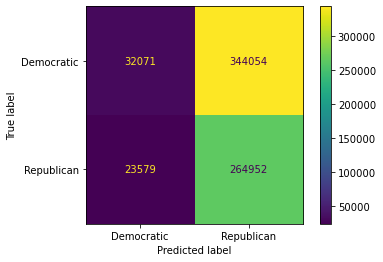



The accuracy of our Naive Bayes model is: 0.447


In [198]:
import matplotlib.pyplot as plt
from sklearn import metrics

actual = [tweet_data[i][1] for i in range(len(tweet_data))]
predicted = [classifier.classify(conv_features(tweet_data[i][0],feature_words)) for i in range(len(tweet_data))] 

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Democratic','Republican'])

cm_display.plot()
plt.show()

def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy
print('\n')
print("The accuracy of our Naive Bayes model is:", round(compute_accuracy(actual, predicted),3))

The accuracy we calculated using the actual and predicted label (0.447) is very similar to the one using 'nltk.classify.accuracy' (0.432), which shows us that Navie Bayes model is not the most accurate model for text classification despite of it's interpretability and simplicity.